In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import sklearn
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from scipy.fft import fft
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

In [3]:
#Define a function that offsets all repeating WaterYear values
def duplicate_years(df):
    # Create a set to keep track of seen values and a dictionary for offsets
    seen = set()
    offsets = {}
    append = 0

    # Increment duplicates
    for idx, year in enumerate(df['WaterYear']):
        if year in seen:
            # Increment the year using the current offset for this value
            offsets[year] += 1
            df.at[idx, 'WaterYear'] = int(year + offsets[year])
        else:
            # First occurrence, initialize offset
            seen.add(year)
            offsets[year] = 0

    df['WaterYear'] = df['WaterYear'].astype('int')
    return df

In [5]:
# Load data
data = pd.read_csv('../Data/final_data_temp.csv')

In [6]:
# Convert WaterYear to date time format and set as index
data["Date"] = pd.to_datetime(data["WaterYear"].astype(str) + "-10-01")
data.set_index("Date", inplace=True)
grouped_data = data.groupby("StationName ")

In [7]:
# Ensure the forecast directory exists
#output_dir = "../Station_Forecasts"
#os.makedirs(output_dir, exist_ok=True)
new_stations = []

In [11]:
# Loop through each unique station and create a model - SARIMAX
for station in list(grouped_data):
    station_name = station[0]
    station = station[1]
    # Resample Station data to ensure consistent frequency and fill any missing dates
    station = duplicate_years(station)
    station.index = pd.to_datetime(station["WaterYear"].astype(str) + "-10-01")
    try:
        station = station.resample("YS-OCT").asfreq()
    except:
        print(station.to_string())

    # Append new stations array for future analysis
    new_stations.append(station)

    # Train SARIMAX model with reduced complexity for sparse data
    model = SARIMAX(
        station["TotalPrecipitation_inches"],
        order=(1, 1, 1),
        seasonal_order=(0, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    sarima_model = model.fit(disp=False)

    # Predict future precipitation values
    predict_years = 80
    pred = sarima_model.get_forecast(steps=predict_years)
    pred_vals = pred.predicted_mean
    pred_ci = pred.conf_int()

    # Create a forecast index based on the last known date and desired frequency
    pred_index = pd.date_range(
        start=station.index[-1] + pd.DateOffset(years=1),
        periods=predict_years,
        freq="AS-Oct",
    )

    # Create forecast series and assign the forecast index
    forecast_series = pd.Series(pred_vals.values, index=pred_index)

    # Adjust the confidence interval index to match forecast index
    forecast_ci = pred_ci.set_index(pred_index)

    # Combine forecast series and confidence interval
    rainfall_forecast_series = pd.concat([forecast_series, forecast_ci], axis=1)

    # Save forecast data to a text file
    with open(f"../Station_Forecasts/{station_name}_forecast.txt", "w") as f:
        f.write(f"Precipitation Forecast for {station_name} Station:\n")
        for row in rainfall_forecast_series.itertuples():
            # Check if row.Index is a datetime object
            if isinstance(row.Index, pd.Timestamp):
                f.write(
                    f"{row.Index.strftime('%Y-%m-%d')}: Prediction: {row[1]:.2f} inches, "
                    f"Lower {row[2]:.2f} inches, Upper {row[3]:.2f} inches\n"
                )
            else:
                f.write(
                    f"{row.Index}: Prediction: {row[1]:.2f} inches, "
                    f"Lower {row[2]:.2f} inches, Upper {row[3]:.2f} inches\n"
                )

    print(
        f"Forecast for {station_name} Station saved to ../Station_Forecasts/{station_name}_forecast.txt"
    )

             StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                     
1951-10-01  Ball Mountain  Tehama                     39.510       1951 -122.780911  39.936369
1952-10-01  Ball Mountain  Tehama                     42.650       1952 -122.780911  39.936369
1953-10-01  Ball Mountain  Tehama                     44.090       1953 -122.780911  39.936369
1954-10-01  Ball Mountain  Tehama                     41.920       1954 -122.780911  39.936369
1955-10-01  Ball Mountain  Tehama                     28.420       1955 -122.780911  39.936369
1956-10-01  Ball Mountain  Tehama                     58.650       1956 -122.780911  39.936369
1957-10-01  Ball Mountain  Tehama                     30.180       1957 -122.780911  39.936369
1958-10-01  Ball Mountain  Tehama                     64.400       1958 -122.780911  39.936369
1959-10-01  Ball Mountain  Tehama                 

c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)


Forecast for Ball Mountain Station saved to ../Station_Forecasts/Ball Mountain_forecast.txt
               StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                       
1948-10-01  Blacks Mountain  Lassen                  25.120000       1948 -121.199842  40.770035
1949-10-01  Blacks Mountain  Lassen                  16.000000       1949 -121.199842  40.770035
1950-10-01  Blacks Mountain  Lassen                  21.360000       1950 -121.199842  40.770035
1951-10-01  Blacks Mountain  Lassen                  22.030000       1951 -121.199842  40.770035
1952-10-01  Blacks Mountain  Lassen                  28.060000       1952 -121.199842  40.770035
1953-10-01  Blacks Mountain  Lassen                  22.530000       1953 -121.199842  40.770035
1954-10-01  Blacks Mountain  Lassen                  18.070000       1954 -121.199842  40.770035
1955-10-01  Blacks Mountain  Lassen

c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)


Forecast for Blacks Mountain Station saved to ../Station_Forecasts/Blacks Mountain_forecast.txt
             StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                     
1970-10-01  Boulder Creek  Plumas                      30.45       1970 -121.199842  40.770035
1971-10-01  Boulder Creek  Plumas                      35.38       1971 -121.199842  40.770035
1972-10-01  Boulder Creek  Plumas                      21.12       1972 -121.199842  40.770035
1973-10-01  Boulder Creek  Plumas                      22.07       1973 -121.199842  40.770035
1974-10-01  Boulder Creek  Plumas                      35.07       1974 -121.199842  40.770035
1975-10-01  Boulder Creek  Plumas                      27.89       1975 -121.199842  40.770035
1976-10-01  Boulder Creek  Plumas                      16.83       1976 -121.199842  40.770035
1977-10-01  Boulder Creek  Plumas                

c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferre

Forecast for Boulder Creek Station saved to ../Station_Forecasts/Boulder Creek_forecast.txt
           StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                   
1961-10-01   Butte Lake  Lassen                  32.820000       1961 -121.300571  40.562129
1962-10-01   Butte Lake  Lassen                  32.050000       1962 -121.300571  40.562129
1963-10-01   Butte Lake  Lassen                  59.200000       1963 -121.300571  40.562129
1964-10-01   Butte Lake  Lassen                  32.150000       1964 -121.300571  40.562129
1965-10-01   Butte Lake  Lassen                  55.930000       1965 -121.300571  40.562129
1966-10-01   Butte Lake  Lassen                  33.400000       1966 -121.300571  40.562129
1967-10-01   Butte Lake  Lassen                  49.250000       1967 -121.300571  40.562129
1968-10-01   Butte Lake  Lassen                  33.600000       1968 -

c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferre

Forecast for Camel Peak Station saved to ../Station_Forecasts/Camel Peak_forecast.txt
           StationName   County  TotalPrecipitation_inches  WaterYear     x_coord   y_coord
WaterYear                                                                                  
1959-10-01  Champs Flat  Lassen                  11.160000       1959 -120.958127  40.69472
1960-10-01  Champs Flat  Lassen                  11.390000       1960 -120.958127  40.69472
1961-10-01  Champs Flat  Lassen                  10.700000       1961 -120.958127  40.69472
1962-10-01  Champs Flat  Lassen                  11.700000       1962 -120.958127  40.69472
1963-10-01  Champs Flat  Lassen                  26.490000       1963 -120.958127  40.69472
1964-10-01  Champs Flat  Lassen                  15.310000       1964 -120.958127  40.69472
1965-10-01  Champs Flat  Lassen                  19.140000       1965 -120.958127  40.69472
1966-10-01  Champs Flat  Lassen                  11.530000       1966 -120.958127  40.

c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)


Forecast for Clarks Peak Station saved to ../Station_Forecasts/Clarks Peak_forecast.txt
             StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                     
1966-10-01  Clover Valley  Plumas                   7.220000       1966 -120.451123  39.944236
1967-10-01  Clover Valley  Plumas                  33.530000       1967 -120.451123  39.944236
1968-10-01  Clover Valley  Plumas                  16.700000       1968 -120.451123  39.944236
1969-10-01  Clover Valley  Plumas                  33.870000       1969 -120.451123  39.944236
1970-10-01  Clover Valley  Plumas                  24.220000       1970 -120.451123  39.944236
1971-10-01  Clover Valley  Plumas                  26.120000       1971 -120.451123  39.944236
1972-10-01  Clover Valley  Plumas                  18.410000       1972 -120.451123  39.944236
1973-10-01  Clover Valley  Plumas                  17.360

c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferre

Forecast for Clover Valley Station saved to ../Station_Forecasts/Clover Valley_forecast.txt
            StationName  County  TotalPrecipitation_inches  WaterYear    x_coord    y_coord
WaterYear                                                                                  
1960-10-01  Crowder Flat  Modoc                      13.27       1960 -120.73377  41.899319
1961-10-01  Crowder Flat  Modoc                      14.15       1961 -120.73377  41.899319
1962-10-01  Crowder Flat  Modoc                      13.81       1962 -120.73377  41.899319
1963-10-01  Crowder Flat  Modoc                      20.11       1963 -120.73377  41.899319
1964-10-01  Crowder Flat  Modoc                      16.72       1964 -120.73377  41.899319
1965-10-01  Crowder Flat  Modoc                      22.90       1965 -120.73377  41.899319
1966-10-01  Crowder Flat  Modoc                      12.85       1966 -120.73377  41.899319
1967-10-01  Crowder Flat  Modoc                      21.25       1967 -120.73377

c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)


Forecast for Dewitt Peak Station saved to ../Station_Forecasts/Dewitt Peak_forecast.txt
               StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                       
1959-10-01  Dodge Reservoir  Lassen                   5.230000       1959 -120.118943  41.005192
1960-10-01  Dodge Reservoir  Lassen                  14.280000       1960 -120.118943  41.005192
1961-10-01  Dodge Reservoir  Lassen                   6.750000       1961 -120.118943  41.005192
1962-10-01  Dodge Reservoir  Lassen                   9.460000       1962 -120.118943  41.005192
1963-10-01  Dodge Reservoir  Lassen                  13.860000       1963 -120.118943  41.005192
1964-10-01  Dodge Reservoir  Lassen                  11.620000       1964 -120.118943  41.005192
1965-10-01  Dodge Reservoir  Lassen                  15.070000       1965 -120.118943  41.005192
1966-10-01  Dodge Reservoir  Lassen    

c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)


Forecast for Dodge Reservoir Station saved to ../Station_Forecasts/Dodge Reservoir_forecast.txt
                StationName     County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                          
1957-10-01  Gazelle Mountain  Siskiyou                  14.450000       1957 -122.673088  41.412434
1958-10-01  Gazelle Mountain  Siskiyou                  24.250000       1958 -122.673088  41.412434
1959-10-01  Gazelle Mountain  Siskiyou                  13.700000       1959 -122.673088  41.412434
1960-10-01  Gazelle Mountain  Siskiyou                  12.500000       1960 -122.673088  41.412434
1961-10-01  Gazelle Mountain  Siskiyou                  11.800000       1961 -122.673088  41.412434
1962-10-01  Gazelle Mountain  Siskiyou                  12.756667       1962 -122.673088  41.412434
1963-10-01  Gazelle Mountain  Siskiyou                  13.713333       1963 -122.673088  41.412434
1964

c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)


Forecast for Gazelle Mountain Station saved to ../Station_Forecasts/Gazelle Mountain_forecast.txt
               StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                       
1969-10-01  Granite Springs  Plumas                      29.40       1969 -120.344061  40.106337
1970-10-01  Granite Springs  Plumas                      22.33       1970 -120.344061  40.106337
1971-10-01  Granite Springs  Plumas                      26.54       1971 -120.344061  40.106337
1972-10-01  Granite Springs  Plumas                      14.50       1972 -120.344061  40.106337
1973-10-01  Granite Springs  Plumas                      15.92       1973 -120.344061  40.106337
1974-10-01  Granite Springs  Plumas                      22.09       1974 -120.344061  40.106337
1975-10-01  Granite Springs  Plumas                      18.82       1975 -120.344061  40.106337
1976-10-01  Granite Springs  

c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)


Forecast for Granite Springs Station saved to ../Station_Forecasts/Granite Springs_forecast.txt
             StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                     
1961-10-01  Hogsback Road  Tehama                     24.600       1961 -122.005063  40.223982
1962-10-01  Hogsback Road  Tehama                     26.200       1962 -122.005063  40.223982
1963-10-01  Hogsback Road  Tehama                     27.800       1963 -122.005063  40.223982
1964-10-01  Hogsback Road  Tehama                     17.070       1964 -122.005063  40.223982
1965-10-01  Hogsback Road  Tehama                     28.580       1965 -122.005063  40.223982
1966-10-01  Hogsback Road  Tehama                     18.090       1966 -122.005063  40.223982
1967-10-01  Hogsback Road  Tehama                     34.820       1967 -122.005063  40.223982
1968-10-01  Hogsback Road  Tehama                

c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)


Forecast for Hogsback Road Station saved to ../Station_Forecasts/Hogsback Road_forecast.txt
            StationName  County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                   
1959-10-01  Lassen Creek  Modoc                      17.35       1959 -120.238747  41.748293
1960-10-01  Lassen Creek  Modoc                      13.93       1960 -120.238747  41.748293
1961-10-01  Lassen Creek  Modoc                       9.15       1961 -120.238747  41.748293
1962-10-01  Lassen Creek  Modoc                      10.71       1962 -120.238747  41.748293
1963-10-01  Lassen Creek  Modoc                      21.96       1963 -120.238747  41.748293
1964-10-01  Lassen Creek  Modoc                      15.13       1964 -120.238747  41.748293
1965-10-01  Lassen Creek  Modoc                      17.00       1965 -120.238747  41.748293
1966-10-01  Lassen Creek  Modoc                      11.03       1966 -

c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)


Forecast for Lassen Creek Station saved to ../Station_Forecasts/Lassen Creek_forecast.txt
            StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                    
1960-10-01  Lights Creek  Plumas                  26.680000       1960 -120.710175  40.229006
1961-10-01  Lights Creek  Plumas                  26.250000       1961 -120.710175  40.229006
1962-10-01  Lights Creek  Plumas                  30.490000       1962 -120.710175  40.229006
1963-10-01  Lights Creek  Plumas                  48.820000       1963 -120.710175  40.229006
1964-10-01  Lights Creek  Plumas                  25.840000       1964 -120.710175  40.229006
1965-10-01  Lights Creek  Plumas                  49.310000       1965 -120.710175  40.229006
1966-10-01  Lights Creek  Plumas                  23.690000       1966 -120.710175  40.229006
1967-10-01  Lights Creek  Plumas                  42.270000     

c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)


Forecast for Lights Creek Station saved to ../Station_Forecasts/Lights Creek_forecast.txt
                  StationName   County  TotalPrecipitation_inches  WaterYear     x_coord   y_coord
WaterYear                                                                                         
1960-10-01  Little Last Chance  Plumas                      13.20       1960 -120.216747  39.96103
1961-10-01  Little Last Chance  Plumas                      15.28       1961 -120.216747  39.96103
1962-10-01  Little Last Chance  Plumas                      17.36       1962 -120.216747  39.96103
1963-10-01  Little Last Chance  Plumas                      27.83       1963 -120.216747  39.96103
1964-10-01  Little Last Chance  Plumas                      15.95       1964 -120.216747  39.96103
1965-10-01  Little Last Chance  Plumas                      22.58       1965 -120.216747  39.96103
1966-10-01  Little Last Chance  Plumas                      11.31       1966 -120.216747  39.96103
1967-10-01  Little 

c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)


Forecast for Little Last Chance Station saved to ../Station_Forecasts/Little Last Chance_forecast.txt
                 StationName  County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                        
1959-10-01  Long Bell Station  Modoc                      16.50       1959 -121.415662  41.473765
1960-10-01  Long Bell Station  Modoc                      19.22       1960 -121.415662  41.473765
1961-10-01  Long Bell Station  Modoc                      20.05       1961 -121.415662  41.473765
1962-10-01  Long Bell Station  Modoc                      23.65       1962 -121.415662  41.473765
1963-10-01  Long Bell Station  Modoc                      36.27       1963 -121.415662  41.473765
1964-10-01  Long Bell Station  Modoc                      20.31       1964 -121.415662  41.473765
1965-10-01  Long Bell Station  Modoc                      34.03       1965 -121.415662  41.473765
1966-10-01  Long

c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)


Forecast for Long Bell Station Station saved to ../Station_Forecasts/Long Bell Station_forecast.txt
              StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                      
1945-10-01  McCarthy Point  Tehama                  15.350000       1945 -121.676234  40.184694
1946-10-01  McCarthy Point  Tehama                  40.400000       1946 -121.676234  40.184694
1947-10-01  McCarthy Point  Tehama                  28.360000       1947 -121.676234  40.184694
1948-10-01  McCarthy Point  Tehama                  49.730000       1948 -121.676234  40.184694
1949-10-01  McCarthy Point  Tehama                  26.150000       1949 -121.676234  40.184694
1950-10-01  McCarthy Point  Tehama                  31.930000       1950 -121.676234  40.184694
1951-10-01  McCarthy Point  Tehama                  43.600000       1951 -121.676234  40.184694
1952-10-01  McCarthy Point  Tehama  

c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)


Forecast for McCarthy Point Station saved to ../Station_Forecasts/McCarthy Point_forecast.txt
             StationName     County  TotalPrecipitation_inches  WaterYear     x_coord   y_coord
WaterYear                                                                                      
1947-10-01  Medicine Lake  Siskiyou                     34.860       1947 -121.616421  41.58738
1948-10-01  Medicine Lake  Siskiyou                     49.310       1948 -121.616421  41.58738
1949-10-01  Medicine Lake  Siskiyou                     25.150       1949 -121.616421  41.58738
1950-10-01  Medicine Lake  Siskiyou                     31.300       1950 -121.616421  41.58738
1951-10-01  Medicine Lake  Siskiyou                     47.210       1951 -121.616421  41.58738
1952-10-01  Medicine Lake  Siskiyou                     53.830       1952 -121.616421  41.58738
1953-10-01  Medicine Lake  Siskiyou                     44.060       1953 -121.616421  41.58738
1954-10-01  Medicine Lake  Siskiyou       

c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)


Forecast for Medicine Lake Station saved to ../Station_Forecasts/Medicine Lake_forecast.txt
           StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                   
1965-10-01  Mount Hough  Plumas                  55.150000       1965 -120.880075  40.041047
1966-10-01  Mount Hough  Plumas                  33.800000       1966 -120.880075  40.041047
1967-10-01  Mount Hough  Plumas                  59.040000       1967 -120.880075  40.041047
1968-10-01  Mount Hough  Plumas                  41.780000       1968 -120.880075  40.041047
1969-10-01  Mount Hough  Plumas                  63.800000       1969 -120.880075  40.041047
1970-10-01  Mount Hough  Plumas                  55.160000       1970 -120.880075  40.041047
1971-10-01  Mount Hough  Plumas                  63.150000       1971 -120.880075  40.041047
1972-10-01  Mount Hough  Plumas                  48.110000       1972 -

c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)


Forecast for Mount Hough Station saved to ../Station_Forecasts/Mount Hough_forecast.txt
            StationName     County  TotalPrecipitation_inches  WaterYear     x_coord   y_coord
WaterYear                                                                                     
1948-10-01  Mount Shasta  Siskiyou                      63.64       1948 -122.233988  41.36229
1949-10-01  Mount Shasta  Siskiyou                      51.16       1949 -122.233988  41.36229
1950-10-01  Mount Shasta  Siskiyou                      51.19       1950 -122.233988  41.36229
1951-10-01  Mount Shasta  Siskiyou                      65.94       1951 -122.233988  41.36229
1952-10-01  Mount Shasta  Siskiyou                      84.21       1952 -122.233988  41.36229
1953-10-01  Mount Shasta  Siskiyou                      73.94       1953 -122.233988  41.36229
1954-10-01  Mount Shasta  Siskiyou                      67.84       1954 -122.233988  41.36229
1955-10-01  Mount Shasta  Siskiyou                      4

c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)


Forecast for Mount Shasta Station saved to ../Station_Forecasts/Mount Shasta_forecast.txt
           StationName    County  TotalPrecipitation_inches  WaterYear    x_coord    y_coord
WaterYear                                                                                   
1947-10-01  Mumbo Basin  Trinity                      40.46       1947 -122.52525  41.197907
1948-10-01  Mumbo Basin  Trinity                      61.68       1948 -122.52525  41.197907
1949-10-01  Mumbo Basin  Trinity                      42.86       1949 -122.52525  41.197907
1950-10-01  Mumbo Basin  Trinity                      33.40       1950 -122.52525  41.197907
1951-10-01  Mumbo Basin  Trinity                      56.61       1951 -122.52525  41.197907
1952-10-01  Mumbo Basin  Trinity                      58.75       1952 -122.52525  41.197907
1953-10-01  Mumbo Basin  Trinity                      67.63       1953 -122.52525  41.197907
1954-10-01  Mumbo Basin  Trinity                      67.80       1954 -1

c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)


Forecast for Mumbo Basin Station saved to ../Station_Forecasts/Mumbo Basin_forecast.txt
            StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                    
1960-10-01  Onion Valley  Plumas                      55.73       1960 -120.884227  39.799262
1961-10-01  Onion Valley  Plumas                      43.58       1961 -120.884227  39.799262
1962-10-01  Onion Valley  Plumas                      48.10       1962 -120.884227  39.799262
1963-10-01  Onion Valley  Plumas                      78.66       1963 -120.884227  39.799262
1964-10-01  Onion Valley  Plumas                      45.19       1964 -120.884227  39.799262
1965-10-01  Onion Valley  Plumas                      77.15       1965 -120.884227  39.799262
1966-10-01  Onion Valley  Plumas                      46.43       1966 -120.884227  39.799262
1967-10-01  Onion Valley  Plumas                      78.45       

c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)


Forecast for Onion Valley Station saved to ../Station_Forecasts/Onion Valley_forecast.txt
                StationName  County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                       
1959-10-01  Patterson Meadow  Modoc                     39.855       1959 -120.198529  41.190193
1960-10-01  Patterson Meadow  Modoc                     19.050       1960 -120.198529  41.190193
1961-10-01  Patterson Meadow  Modoc                     17.700       1961 -120.198529  41.190193
1962-10-01  Patterson Meadow  Modoc                     21.070       1962 -120.198529  41.190193
1963-10-01  Patterson Meadow  Modoc                     28.440       1963 -120.198529  41.190193
1964-10-01  Patterson Meadow  Modoc                     26.290       1964 -120.198529  41.190193
1965-10-01  Patterson Meadow  Modoc                     27.220       1965 -120.198529  41.190193
1966-10-01  Patterson Meadow  Modoc  

c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)


Forecast for Patterson Meadow Station saved to ../Station_Forecasts/Patterson Meadow_forecast.txt
               StationName  County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                      
1959-10-01  Pepperdine Camp  Modoc                     16.430       1959 -120.246323  41.454164
1960-10-01  Pepperdine Camp  Modoc                     19.870       1960 -120.246323  41.454164
1961-10-01  Pepperdine Camp  Modoc                     19.635       1961 -120.246323  41.454164
1962-10-01  Pepperdine Camp  Modoc                     19.400       1962 -120.246323  41.454164
1963-10-01  Pepperdine Camp  Modoc                     31.350       1963 -120.246323  41.454164
1964-10-01  Pepperdine Camp  Modoc                     25.170       1964 -120.246323  41.454164
1965-10-01  Pepperdine Camp  Modoc                     26.770       1965 -120.246323  41.454164
1966-10-01  Pepperdine Camp  Modoc    

c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)


Forecast for Pepperdine Camp Station saved to ../Station_Forecasts/Pepperdine Camp_forecast.txt
               StationName  County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                      
1961-10-01  Plaskett Meadow   Glen                      48.30       1961 -122.857873  39.735429
1962-10-01  Plaskett Meadow   Glen                      49.04       1962 -122.857873  39.735429
1963-10-01  Plaskett Meadow   Glen                      54.24       1963 -122.857873  39.735429
1964-10-01  Plaskett Meadow   Glen                      45.55       1964 -122.857873  39.735429
1965-10-01  Plaskett Meadow   Glen                      93.25       1965 -122.857873  39.735429
1966-10-01  Plaskett Meadow   Glen                      46.45       1966 -122.857873  39.735429
1967-10-01  Plaskett Meadow   Glen                      66.24       1967 -122.857873  39.735429
1968-10-01  Plaskett Meadow   Glen      

c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)


Forecast for Plaskett Meadow Station saved to ../Station_Forecasts/Plaskett Meadow_forecast.txt
           StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                   
1946-10-01  Saddle Camp  Tehama                      20.00       1946 -122.801191  40.165379
1947-10-01  Saddle Camp  Tehama                      18.15       1947 -122.801191  40.165379
1948-10-01  Saddle Camp  Tehama                      26.25       1948 -122.801191  40.165379
1949-10-01  Saddle Camp  Tehama                      28.13       1949 -122.801191  40.165379
1950-10-01  Saddle Camp  Tehama                      23.19       1950 -122.801191  40.165379
1951-10-01  Saddle Camp  Tehama                      30.88       1951 -122.801191  40.165379
1952-10-01  Saddle Camp  Tehama                      39.69       1952 -122.801191  40.165379
1953-10-01  Saddle Camp  Tehama                      34.97       19

c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-

Forecast for Saddle Camp Station saved to ../Station_Forecasts/Saddle Camp_forecast.txt
                StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                        
1991-10-01  Shaffer Mountain  Lassen                  18.200000       1991 -120.357534  40.447365
1992-10-01  Shaffer Mountain  Lassen                  14.200000       1992 -120.357534  40.447365
1993-10-01  Shaffer Mountain  Lassen                  36.970000       1993 -120.357534  40.447365
1994-10-01  Shaffer Mountain  Lassen                  19.680000       1994 -120.357534  40.447365
1995-10-01  Shaffer Mountain  Lassen                  44.750000       1995 -120.357534  40.447365
1996-10-01  Shaffer Mountain  Lassen                  42.070000       1996 -120.357534  40.447365
1997-10-01  Shaffer Mountain  Lassen                   9.800000       1997 -120.357534  40.447365
1998-10-01  Shaffer Mountain  

c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)


Forecast for Stouts Meadow Station saved to ../Station_Forecasts/Stouts Meadow_forecast.txt
              StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                      
1959-10-01  Swain Mountain  Lassen                    41.1900       1959 -121.100349  40.444958
1960-10-01  Swain Mountain  Lassen                    44.1200       1960 -121.100349  40.444958
1961-10-01  Swain Mountain  Lassen                    45.3300       1961 -121.100349  40.444958
1962-10-01  Swain Mountain  Lassen                    50.6500       1962 -121.100349  40.444958
1963-10-01  Swain Mountain  Lassen                    48.5600       1963 -121.100349  40.444958
1964-10-01  Swain Mountain  Lassen                    41.5100       1964 -121.100349  40.444958
1965-10-01  Swain Mountain  Lassen                    63.4200       1965 -121.100349  40.444958
1966-10-01  Swain Mountain  Lassen          

c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)


Forecast for Swain Mountain Station saved to ../Station_Forecasts/Swain Mountain_forecast.txt
             StationName  County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                    
1959-10-01  Sweagert Flat  Modoc                      15.61       1959 -120.794337  41.237361
1960-10-01  Sweagert Flat  Modoc                      19.07       1960 -120.794337  41.237361
1961-10-01  Sweagert Flat  Modoc                      19.30       1961 -120.794337  41.237361
1962-10-01  Sweagert Flat  Modoc                      21.34       1962 -120.794337  41.237361
1963-10-01  Sweagert Flat  Modoc                      31.12       1963 -120.794337  41.237361
1964-10-01  Sweagert Flat  Modoc                      22.97       1964 -120.794337  41.237361
1965-10-01  Sweagert Flat  Modoc                      31.91       1965 -120.794337  41.237361
1966-10-01  Sweagert Flat  Modoc                      18.23 

c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\dfang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferre

Forecast for Sweagert Flat Station saved to ../Station_Forecasts/Sweagert Flat_forecast.txt
                 StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                         
1960-10-01  Three Mile Valley  Plumas                  28.610000       1960 -120.571455  39.901697
1961-10-01  Three Mile Valley  Plumas                  20.870000       1961 -120.571455  39.901697
1962-10-01  Three Mile Valley  Plumas                  26.260000       1962 -120.571455  39.901697
1963-10-01  Three Mile Valley  Plumas                  49.140000       1963 -120.571455  39.901697
1964-10-01  Three Mile Valley  Plumas                  20.570000       1964 -120.571455  39.901697
1965-10-01  Three Mile Valley  Plumas                  47.440000       1965 -120.571455  39.901697
1966-10-01  Three Mile Valley  Plumas                  25.590000       1966 -120.571455  39.901697
1967-10-01  Three

Note: Certain collection locations have inaccurate or flat-out wrong SARIMAX Predictions:

* Ball Mountain (negative values)
* Boulder Creek (Very high values for CI)
* Camel Peak (negative values)
* Clover Valley (very high values for CI)
* Granite Springs (very high values for CI)
* Medicine Lake (one negative value)
* Mount Hough (very high values for CI)
* Swain Mountain (negative values)

There are also some where the MLE failed to converge

In [12]:
# Creating lag features for time-series data
def create_lag_features(data, lag_steps=1):
    for i in range(1, lag_steps + 1):
        data[f'lag_{i}'] = data["TotalPrecipitation_inches"].shift(i)
    return data

In [13]:
# Creating rolling mean for time-series data
def create_rolling_mean(data, window_size=3):
    data['rolling_mean'] = data["TotalPrecipitation_inches"].rolling(window=window_size).mean()
    return data

In [14]:
# Applying Fourier transformation for capturing seasonality
def apply_fourier_transform(data):
    values = data['TotalPrecipitation_inches'].values
    fourier_transform = fft(values)
    data['fourier_transform'] = np.abs(fourier_transform)
    return data

             StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                     
1951-10-01  Ball Mountain  Tehama                     39.510       1951 -122.780911  39.936369
1952-10-01  Ball Mountain  Tehama                     42.650       1952 -122.780911  39.936369
1953-10-01  Ball Mountain  Tehama                     44.090       1953 -122.780911  39.936369
1954-10-01  Ball Mountain  Tehama                     41.920       1954 -122.780911  39.936369
1955-10-01  Ball Mountain  Tehama                     28.420       1955 -122.780911  39.936369
1956-10-01  Ball Mountain  Tehama                     58.650       1956 -122.780911  39.936369
1957-10-01  Ball Mountain  Tehama                     30.180       1957 -122.780911  39.936369
1958-10-01  Ball Mountain  Tehama                     64.400       1958 -122.780911  39.936369
1959-10-01  Ball Mountain  Tehama                 

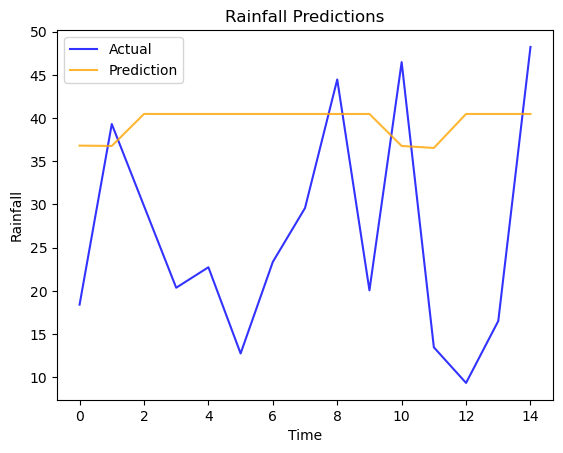

               StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                       
1948-10-01  Blacks Mountain  Lassen                  25.120000       1948 -121.199842  40.770035
1949-10-01  Blacks Mountain  Lassen                  16.000000       1949 -121.199842  40.770035
1950-10-01  Blacks Mountain  Lassen                  21.360000       1950 -121.199842  40.770035
1951-10-01  Blacks Mountain  Lassen                  22.030000       1951 -121.199842  40.770035
1952-10-01  Blacks Mountain  Lassen                  28.060000       1952 -121.199842  40.770035
1953-10-01  Blacks Mountain  Lassen                  22.530000       1953 -121.199842  40.770035
1954-10-01  Blacks Mountain  Lassen                  18.070000       1954 -121.199842  40.770035
1955-10-01  Blacks Mountain  Lassen                  14.060000       1955 -121.199842  40.770035
1956-10-01  Blacks Mountain  L

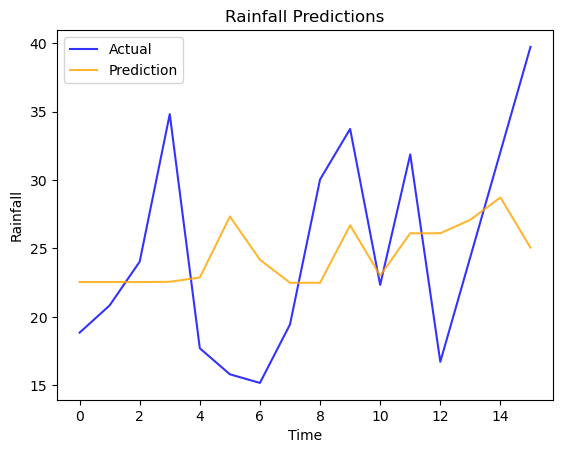

             StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                     
1970-10-01  Boulder Creek  Plumas                      30.45       1970 -121.199842  40.770035
1971-10-01  Boulder Creek  Plumas                      35.38       1971 -121.199842  40.770035
1972-10-01  Boulder Creek  Plumas                      21.12       1972 -121.199842  40.770035
1973-10-01  Boulder Creek  Plumas                      22.07       1973 -121.199842  40.770035
1974-10-01  Boulder Creek  Plumas                      35.07       1974 -121.199842  40.770035
1975-10-01  Boulder Creek  Plumas                      27.89       1975 -121.199842  40.770035
1976-10-01  Boulder Creek  Plumas                      16.83       1976 -121.199842  40.770035
1977-10-01  Boulder Creek  Plumas                      10.91       1977 -121.199842  40.770035
1978-10-01  Boulder Creek  Plumas                 

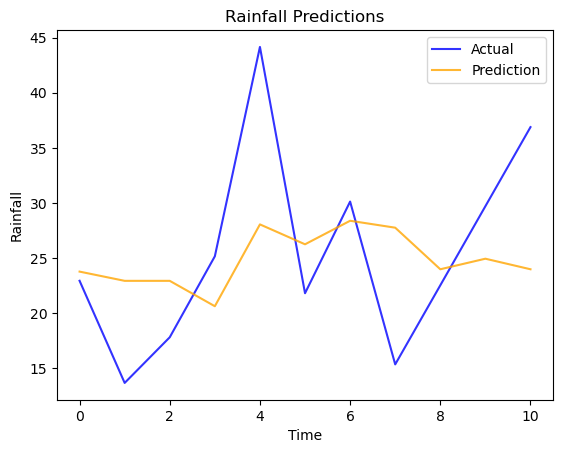

           StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                   
1961-10-01   Butte Lake  Lassen                  32.820000       1961 -121.300571  40.562129
1962-10-01   Butte Lake  Lassen                  32.050000       1962 -121.300571  40.562129
1963-10-01   Butte Lake  Lassen                  59.200000       1963 -121.300571  40.562129
1964-10-01   Butte Lake  Lassen                  32.150000       1964 -121.300571  40.562129
1965-10-01   Butte Lake  Lassen                  55.930000       1965 -121.300571  40.562129
1966-10-01   Butte Lake  Lassen                  33.400000       1966 -121.300571  40.562129
1967-10-01   Butte Lake  Lassen                  49.250000       1967 -121.300571  40.562129
1968-10-01   Butte Lake  Lassen                  33.600000       1968 -121.300571  40.562129
1969-10-01   Butte Lake  Lassen                  54.200000       1969 

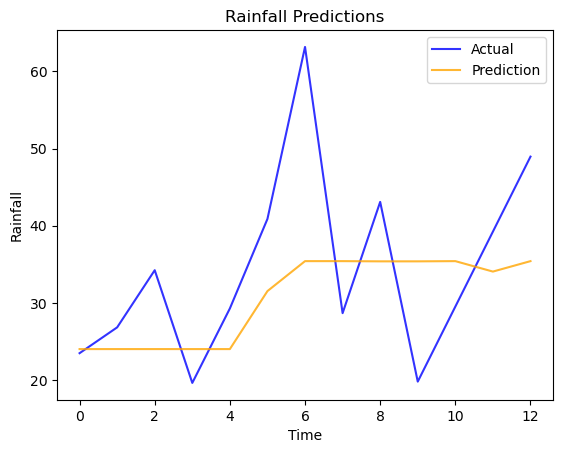

           StationName   County  TotalPrecipitation_inches  WaterYear    x_coord    y_coord
WaterYear                                                                                  
1968-10-01   Camel Peak  Plumas                  34.460000       1968 -121.10115  39.724185
1969-10-01   Camel Peak  Plumas                  85.790000       1969 -121.10115  39.724185
1970-10-01   Camel Peak  Plumas                  87.260000       1970 -121.10115  39.724185
1971-10-01   Camel Peak  Plumas                  74.220000       1971 -121.10115  39.724185
1972-10-01   Camel Peak  Plumas                  50.190000       1972 -121.10115  39.724185
1973-10-01   Camel Peak  Plumas                  71.550000       1973 -121.10115  39.724185
1974-10-01   Camel Peak  Plumas                 113.600000       1974 -121.10115  39.724185
1975-10-01   Camel Peak  Plumas                  70.450000       1975 -121.10115  39.724185
1976-10-01   Camel Peak  Plumas                  41.100000       1976 -121.10115

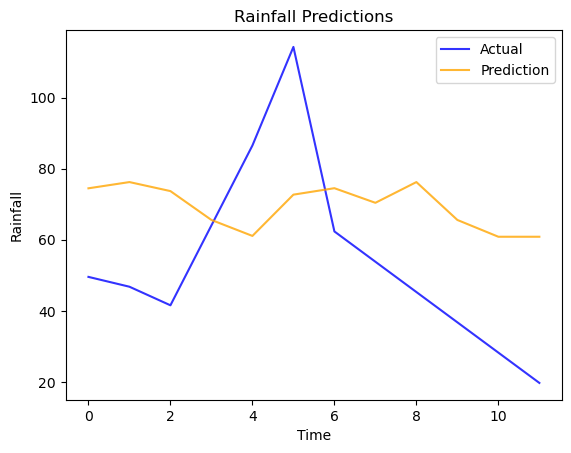

           StationName   County  TotalPrecipitation_inches  WaterYear     x_coord   y_coord
WaterYear                                                                                  
1959-10-01  Champs Flat  Lassen                  11.160000       1959 -120.958127  40.69472
1960-10-01  Champs Flat  Lassen                  11.390000       1960 -120.958127  40.69472
1961-10-01  Champs Flat  Lassen                  10.700000       1961 -120.958127  40.69472
1962-10-01  Champs Flat  Lassen                  11.700000       1962 -120.958127  40.69472
1963-10-01  Champs Flat  Lassen                  26.490000       1963 -120.958127  40.69472
1964-10-01  Champs Flat  Lassen                  15.310000       1964 -120.958127  40.69472
1965-10-01  Champs Flat  Lassen                  19.140000       1965 -120.958127  40.69472
1966-10-01  Champs Flat  Lassen                  11.530000       1966 -120.958127  40.69472
1967-10-01  Champs Flat  Lassen                  19.650000       1967 -120.95812

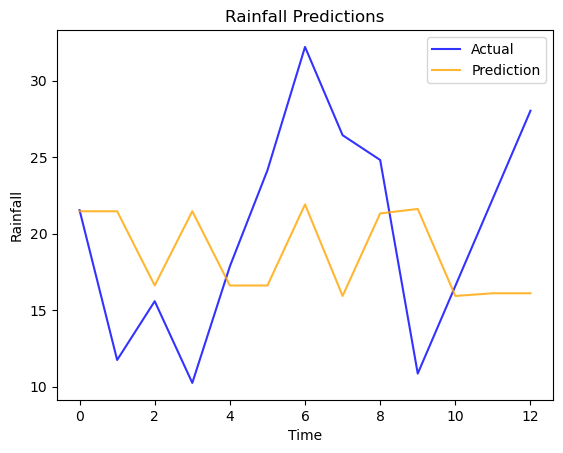

           StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                   
1959-10-01  Clarks Peak  Plumas                  17.100000       1959 -120.493576  40.213588
1960-10-01  Clarks Peak  Plumas                  18.300000       1960 -120.493576  40.213588
1961-10-01  Clarks Peak  Plumas                  17.880000       1961 -120.493576  40.213588
1962-10-01  Clarks Peak  Plumas                  20.890000       1962 -120.493576  40.213588
1963-10-01  Clarks Peak  Plumas                  29.540000       1963 -120.493576  40.213588
1964-10-01  Clarks Peak  Plumas                  15.600000       1964 -120.493576  40.213588
1965-10-01  Clarks Peak  Plumas                  29.310000       1965 -120.493576  40.213588
1966-10-01  Clarks Peak  Plumas                  10.740000       1966 -120.493576  40.213588
1967-10-01  Clarks Peak  Plumas                  27.470000       1967 

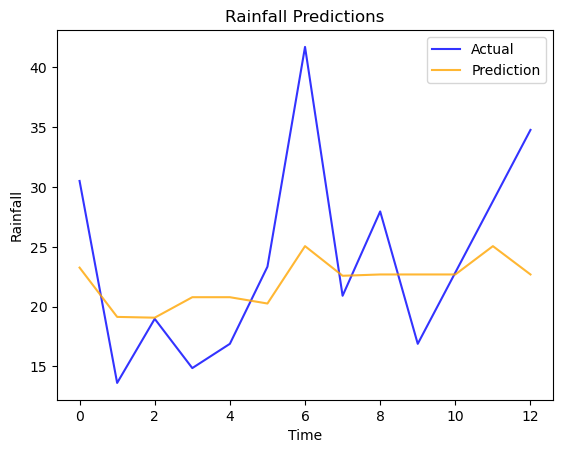

             StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                     
1966-10-01  Clover Valley  Plumas                   7.220000       1966 -120.451123  39.944236
1967-10-01  Clover Valley  Plumas                  33.530000       1967 -120.451123  39.944236
1968-10-01  Clover Valley  Plumas                  16.700000       1968 -120.451123  39.944236
1969-10-01  Clover Valley  Plumas                  33.870000       1969 -120.451123  39.944236
1970-10-01  Clover Valley  Plumas                  24.220000       1970 -120.451123  39.944236
1971-10-01  Clover Valley  Plumas                  26.120000       1971 -120.451123  39.944236
1972-10-01  Clover Valley  Plumas                  18.410000       1972 -120.451123  39.944236
1973-10-01  Clover Valley  Plumas                  17.360000       1973 -120.451123  39.944236
1974-10-01  Clover Valley  Plumas                 

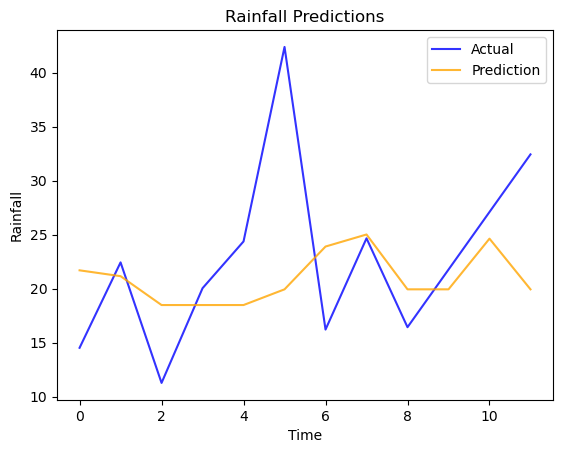

            StationName  County  TotalPrecipitation_inches  WaterYear    x_coord    y_coord
WaterYear                                                                                  
1960-10-01  Crowder Flat  Modoc                      13.27       1960 -120.73377  41.899319
1961-10-01  Crowder Flat  Modoc                      14.15       1961 -120.73377  41.899319
1962-10-01  Crowder Flat  Modoc                      13.81       1962 -120.73377  41.899319
1963-10-01  Crowder Flat  Modoc                      20.11       1963 -120.73377  41.899319
1964-10-01  Crowder Flat  Modoc                      16.72       1964 -120.73377  41.899319
1965-10-01  Crowder Flat  Modoc                      22.90       1965 -120.73377  41.899319
1966-10-01  Crowder Flat  Modoc                      12.85       1966 -120.73377  41.899319
1967-10-01  Crowder Flat  Modoc                      21.25       1967 -120.73377  41.899319
1968-10-01  Crowder Flat  Modoc                      12.10       1968 -120.73377

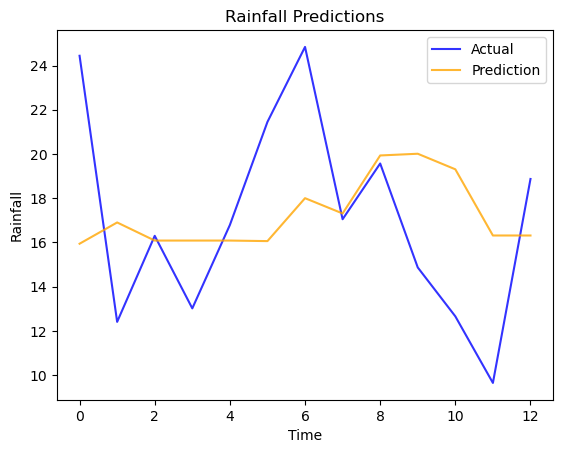

           StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                   
1961-10-01  Dewitt Peak  Tehama                      24.45       1961 -121.974141  40.143699
1962-10-01  Dewitt Peak  Tehama                      22.20       1962 -121.974141  40.143699
1963-10-01  Dewitt Peak  Tehama                      26.18       1963 -121.974141  40.143699
1964-10-01  Dewitt Peak  Tehama                      15.24       1964 -121.974141  40.143699
1965-10-01  Dewitt Peak  Tehama                      28.26       1965 -121.974141  40.143699
1966-10-01  Dewitt Peak  Tehama                      16.33       1966 -121.974141  40.143699
1967-10-01  Dewitt Peak  Tehama                      30.98       1967 -121.974141  40.143699
1968-10-01  Dewitt Peak  Tehama                      20.28       1968 -121.974141  40.143699
1969-10-01  Dewitt Peak  Tehama                      41.79       1969 

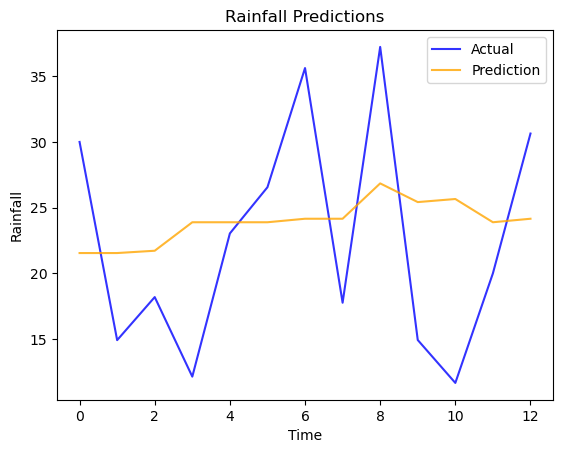

               StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                       
1959-10-01  Dodge Reservoir  Lassen                   5.230000       1959 -120.118943  41.005192
1960-10-01  Dodge Reservoir  Lassen                  14.280000       1960 -120.118943  41.005192
1961-10-01  Dodge Reservoir  Lassen                   6.750000       1961 -120.118943  41.005192
1962-10-01  Dodge Reservoir  Lassen                   9.460000       1962 -120.118943  41.005192
1963-10-01  Dodge Reservoir  Lassen                  13.860000       1963 -120.118943  41.005192
1964-10-01  Dodge Reservoir  Lassen                  11.620000       1964 -120.118943  41.005192
1965-10-01  Dodge Reservoir  Lassen                  15.070000       1965 -120.118943  41.005192
1966-10-01  Dodge Reservoir  Lassen                   7.950000       1966 -120.118943  41.005192
1967-10-01  Dodge Reservoir  L

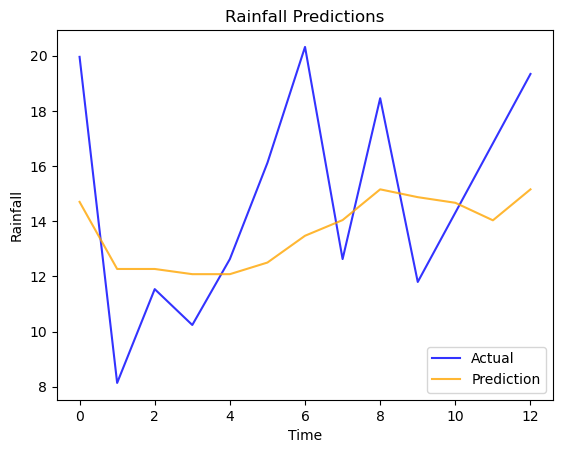

                StationName     County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                          
1957-10-01  Gazelle Mountain  Siskiyou                  14.450000       1957 -122.673088  41.412434
1958-10-01  Gazelle Mountain  Siskiyou                  24.250000       1958 -122.673088  41.412434
1959-10-01  Gazelle Mountain  Siskiyou                  13.700000       1959 -122.673088  41.412434
1960-10-01  Gazelle Mountain  Siskiyou                  12.500000       1960 -122.673088  41.412434
1961-10-01  Gazelle Mountain  Siskiyou                  11.800000       1961 -122.673088  41.412434
1962-10-01  Gazelle Mountain  Siskiyou                  12.756667       1962 -122.673088  41.412434
1963-10-01  Gazelle Mountain  Siskiyou                  13.713333       1963 -122.673088  41.412434
1964-10-01  Gazelle Mountain  Siskiyou                  14.670000       1964 -122.673088  41.412434


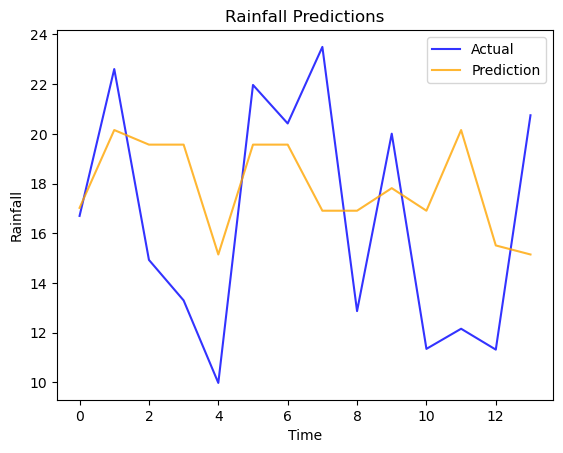

               StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                       
1969-10-01  Granite Springs  Plumas                      29.40       1969 -120.344061  40.106337
1970-10-01  Granite Springs  Plumas                      22.33       1970 -120.344061  40.106337
1971-10-01  Granite Springs  Plumas                      26.54       1971 -120.344061  40.106337
1972-10-01  Granite Springs  Plumas                      14.50       1972 -120.344061  40.106337
1973-10-01  Granite Springs  Plumas                      15.92       1973 -120.344061  40.106337
1974-10-01  Granite Springs  Plumas                      22.09       1974 -120.344061  40.106337
1975-10-01  Granite Springs  Plumas                      18.82       1975 -120.344061  40.106337
1976-10-01  Granite Springs  Plumas                      12.51       1976 -120.344061  40.106337
1977-10-01  Granite Springs  P

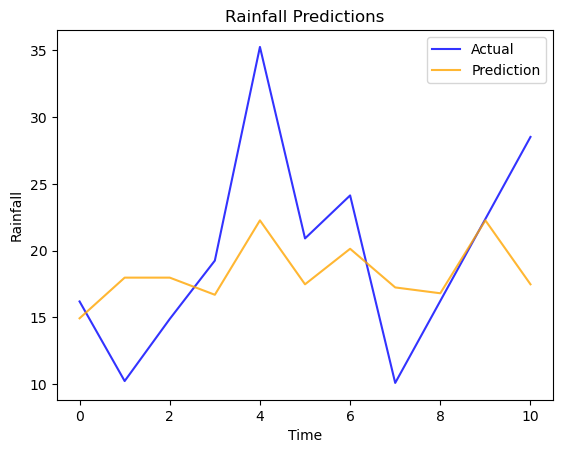

             StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                     
1961-10-01  Hogsback Road  Tehama                     24.600       1961 -122.005063  40.223982
1962-10-01  Hogsback Road  Tehama                     26.200       1962 -122.005063  40.223982
1963-10-01  Hogsback Road  Tehama                     27.800       1963 -122.005063  40.223982
1964-10-01  Hogsback Road  Tehama                     17.070       1964 -122.005063  40.223982
1965-10-01  Hogsback Road  Tehama                     28.580       1965 -122.005063  40.223982
1966-10-01  Hogsback Road  Tehama                     18.090       1966 -122.005063  40.223982
1967-10-01  Hogsback Road  Tehama                     34.820       1967 -122.005063  40.223982
1968-10-01  Hogsback Road  Tehama                     21.260       1968 -122.005063  40.223982
1969-10-01  Hogsback Road  Tehama                 

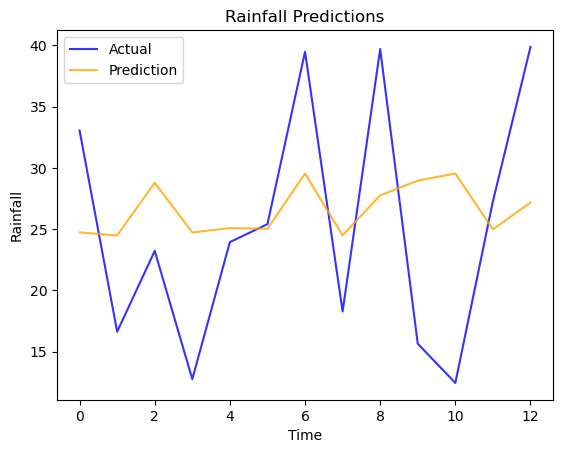

            StationName  County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                   
1959-10-01  Lassen Creek  Modoc                      17.35       1959 -120.238747  41.748293
1960-10-01  Lassen Creek  Modoc                      13.93       1960 -120.238747  41.748293
1961-10-01  Lassen Creek  Modoc                       9.15       1961 -120.238747  41.748293
1962-10-01  Lassen Creek  Modoc                      10.71       1962 -120.238747  41.748293
1963-10-01  Lassen Creek  Modoc                      21.96       1963 -120.238747  41.748293
1964-10-01  Lassen Creek  Modoc                      15.13       1964 -120.238747  41.748293
1965-10-01  Lassen Creek  Modoc                      17.00       1965 -120.238747  41.748293
1966-10-01  Lassen Creek  Modoc                      11.03       1966 -120.238747  41.748293
1967-10-01  Lassen Creek  Modoc                      19.57       1967 

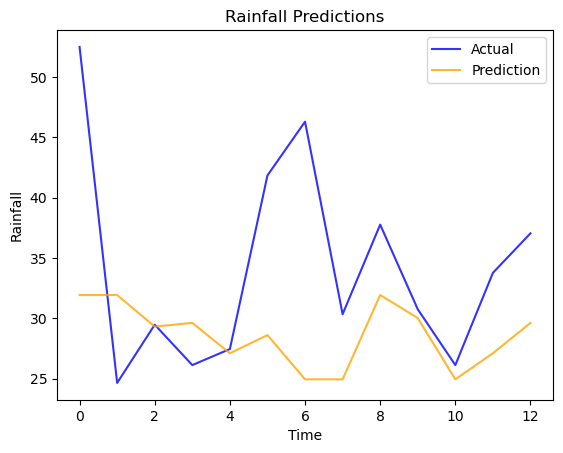

            StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                    
1960-10-01  Lights Creek  Plumas                  26.680000       1960 -120.710175  40.229006
1961-10-01  Lights Creek  Plumas                  26.250000       1961 -120.710175  40.229006
1962-10-01  Lights Creek  Plumas                  30.490000       1962 -120.710175  40.229006
1963-10-01  Lights Creek  Plumas                  48.820000       1963 -120.710175  40.229006
1964-10-01  Lights Creek  Plumas                  25.840000       1964 -120.710175  40.229006
1965-10-01  Lights Creek  Plumas                  49.310000       1965 -120.710175  40.229006
1966-10-01  Lights Creek  Plumas                  23.690000       1966 -120.710175  40.229006
1967-10-01  Lights Creek  Plumas                  42.270000       1967 -120.710175  40.229006
1968-10-01  Lights Creek  Plumas                  30.430000 

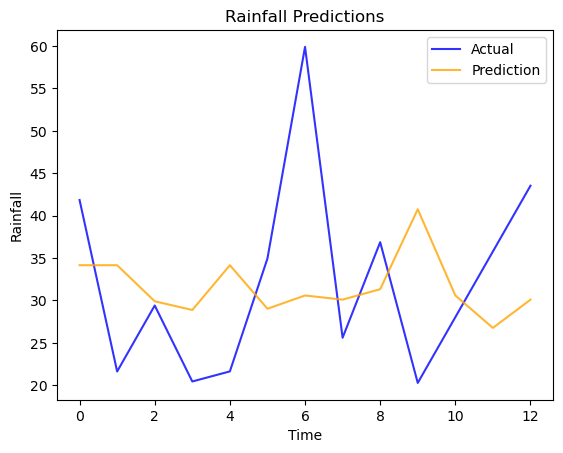

                  StationName   County  TotalPrecipitation_inches  WaterYear     x_coord   y_coord
WaterYear                                                                                         
1960-10-01  Little Last Chance  Plumas                      13.20       1960 -120.216747  39.96103
1961-10-01  Little Last Chance  Plumas                      15.28       1961 -120.216747  39.96103
1962-10-01  Little Last Chance  Plumas                      17.36       1962 -120.216747  39.96103
1963-10-01  Little Last Chance  Plumas                      27.83       1963 -120.216747  39.96103
1964-10-01  Little Last Chance  Plumas                      15.95       1964 -120.216747  39.96103
1965-10-01  Little Last Chance  Plumas                      22.58       1965 -120.216747  39.96103
1966-10-01  Little Last Chance  Plumas                      11.31       1966 -120.216747  39.96103
1967-10-01  Little Last Chance  Plumas                      24.26       1967 -120.216747  39.96103
1968-10-01

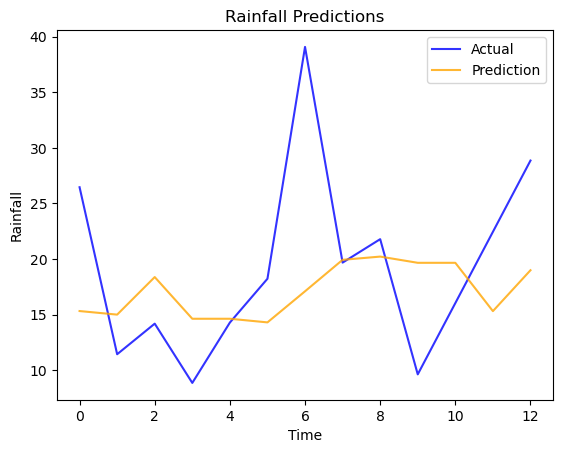

                 StationName  County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                        
1959-10-01  Long Bell Station  Modoc                      16.50       1959 -121.415662  41.473765
1960-10-01  Long Bell Station  Modoc                      19.22       1960 -121.415662  41.473765
1961-10-01  Long Bell Station  Modoc                      20.05       1961 -121.415662  41.473765
1962-10-01  Long Bell Station  Modoc                      23.65       1962 -121.415662  41.473765
1963-10-01  Long Bell Station  Modoc                      36.27       1963 -121.415662  41.473765
1964-10-01  Long Bell Station  Modoc                      20.31       1964 -121.415662  41.473765
1965-10-01  Long Bell Station  Modoc                      34.03       1965 -121.415662  41.473765
1966-10-01  Long Bell Station  Modoc                      20.59       1966 -121.415662  41.473765
1967-10-01  Long Bel

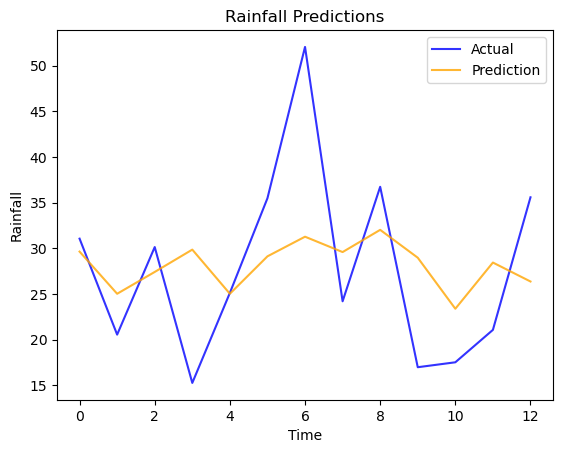

              StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                      
1945-10-01  McCarthy Point  Tehama                  15.350000       1945 -121.676234  40.184694
1946-10-01  McCarthy Point  Tehama                  40.400000       1946 -121.676234  40.184694
1947-10-01  McCarthy Point  Tehama                  28.360000       1947 -121.676234  40.184694
1948-10-01  McCarthy Point  Tehama                  49.730000       1948 -121.676234  40.184694
1949-10-01  McCarthy Point  Tehama                  26.150000       1949 -121.676234  40.184694
1950-10-01  McCarthy Point  Tehama                  31.930000       1950 -121.676234  40.184694
1951-10-01  McCarthy Point  Tehama                  43.600000       1951 -121.676234  40.184694
1952-10-01  McCarthy Point  Tehama                  55.820000       1952 -121.676234  40.184694
1953-10-01  McCarthy Point  Tehama      

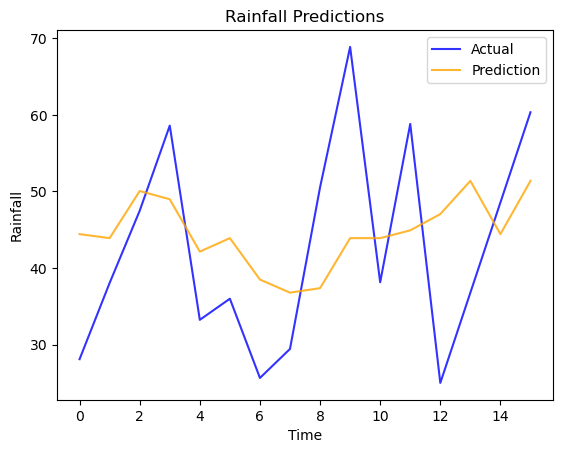

             StationName     County  TotalPrecipitation_inches  WaterYear     x_coord   y_coord
WaterYear                                                                                      
1947-10-01  Medicine Lake  Siskiyou                     34.860       1947 -121.616421  41.58738
1948-10-01  Medicine Lake  Siskiyou                     49.310       1948 -121.616421  41.58738
1949-10-01  Medicine Lake  Siskiyou                     25.150       1949 -121.616421  41.58738
1950-10-01  Medicine Lake  Siskiyou                     31.300       1950 -121.616421  41.58738
1951-10-01  Medicine Lake  Siskiyou                     47.210       1951 -121.616421  41.58738
1952-10-01  Medicine Lake  Siskiyou                     53.830       1952 -121.616421  41.58738
1953-10-01  Medicine Lake  Siskiyou                     44.060       1953 -121.616421  41.58738
1954-10-01  Medicine Lake  Siskiyou                     45.590       1954 -121.616421  41.58738
1955-10-01  Medicine Lake  Siskiyou     

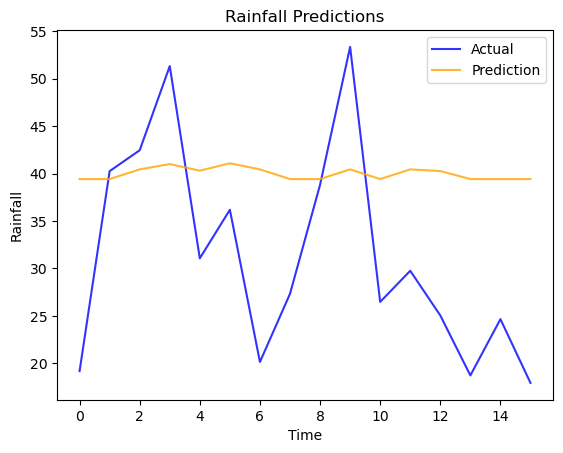

           StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                   
1965-10-01  Mount Hough  Plumas                  55.150000       1965 -120.880075  40.041047
1966-10-01  Mount Hough  Plumas                  33.800000       1966 -120.880075  40.041047
1967-10-01  Mount Hough  Plumas                  59.040000       1967 -120.880075  40.041047
1968-10-01  Mount Hough  Plumas                  41.780000       1968 -120.880075  40.041047
1969-10-01  Mount Hough  Plumas                  63.800000       1969 -120.880075  40.041047
1970-10-01  Mount Hough  Plumas                  55.160000       1970 -120.880075  40.041047
1971-10-01  Mount Hough  Plumas                  63.150000       1971 -120.880075  40.041047
1972-10-01  Mount Hough  Plumas                  48.110000       1972 -120.880075  40.041047
1973-10-01  Mount Hough  Plumas                  49.240000       1973 

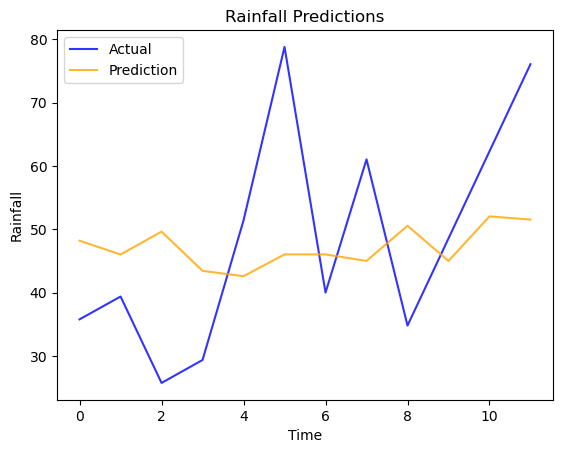

            StationName     County  TotalPrecipitation_inches  WaterYear     x_coord   y_coord
WaterYear                                                                                     
1948-10-01  Mount Shasta  Siskiyou                      63.64       1948 -122.233988  41.36229
1949-10-01  Mount Shasta  Siskiyou                      51.16       1949 -122.233988  41.36229
1950-10-01  Mount Shasta  Siskiyou                      51.19       1950 -122.233988  41.36229
1951-10-01  Mount Shasta  Siskiyou                      65.94       1951 -122.233988  41.36229
1952-10-01  Mount Shasta  Siskiyou                      84.21       1952 -122.233988  41.36229
1953-10-01  Mount Shasta  Siskiyou                      73.94       1953 -122.233988  41.36229
1954-10-01  Mount Shasta  Siskiyou                      67.84       1954 -122.233988  41.36229
1955-10-01  Mount Shasta  Siskiyou                      44.50       1955 -122.233988  41.36229
1956-10-01  Mount Shasta  Siskiyou                

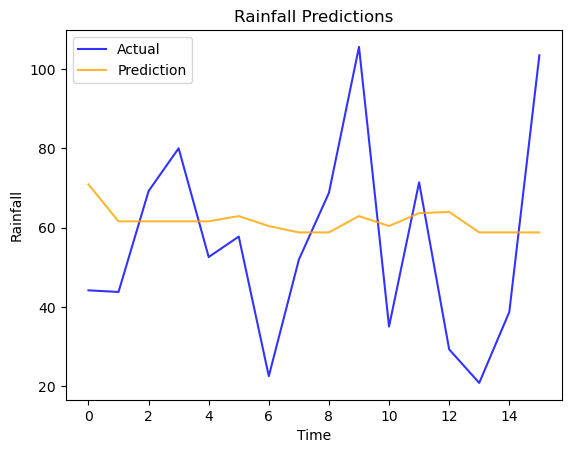

           StationName    County  TotalPrecipitation_inches  WaterYear    x_coord    y_coord
WaterYear                                                                                   
1947-10-01  Mumbo Basin  Trinity                      40.46       1947 -122.52525  41.197907
1948-10-01  Mumbo Basin  Trinity                      61.68       1948 -122.52525  41.197907
1949-10-01  Mumbo Basin  Trinity                      42.86       1949 -122.52525  41.197907
1950-10-01  Mumbo Basin  Trinity                      33.40       1950 -122.52525  41.197907
1951-10-01  Mumbo Basin  Trinity                      56.61       1951 -122.52525  41.197907
1952-10-01  Mumbo Basin  Trinity                      58.75       1952 -122.52525  41.197907
1953-10-01  Mumbo Basin  Trinity                      67.63       1953 -122.52525  41.197907
1954-10-01  Mumbo Basin  Trinity                      67.80       1954 -122.52525  41.197907
1955-10-01  Mumbo Basin  Trinity                      31.30       1955

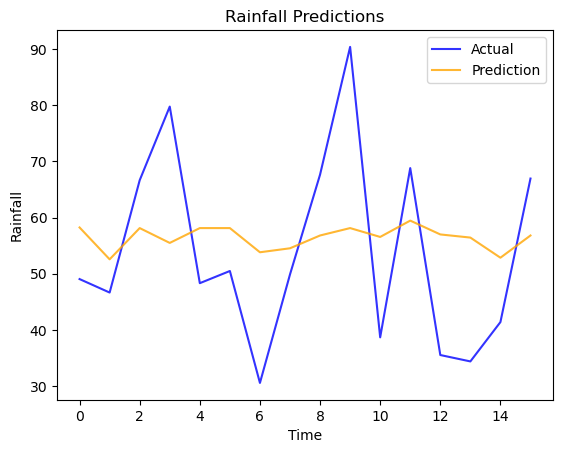

            StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                    
1960-10-01  Onion Valley  Plumas                      55.73       1960 -120.884227  39.799262
1961-10-01  Onion Valley  Plumas                      43.58       1961 -120.884227  39.799262
1962-10-01  Onion Valley  Plumas                      48.10       1962 -120.884227  39.799262
1963-10-01  Onion Valley  Plumas                      78.66       1963 -120.884227  39.799262
1964-10-01  Onion Valley  Plumas                      45.19       1964 -120.884227  39.799262
1965-10-01  Onion Valley  Plumas                      77.15       1965 -120.884227  39.799262
1966-10-01  Onion Valley  Plumas                      46.43       1966 -120.884227  39.799262
1967-10-01  Onion Valley  Plumas                      78.45       1967 -120.884227  39.799262
1968-10-01  Onion Valley  Plumas                      51.22 

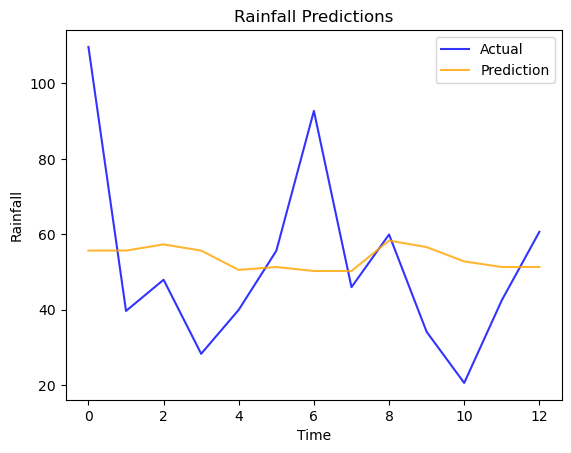

                StationName  County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                       
1959-10-01  Patterson Meadow  Modoc                     39.855       1959 -120.198529  41.190193
1960-10-01  Patterson Meadow  Modoc                     19.050       1960 -120.198529  41.190193
1961-10-01  Patterson Meadow  Modoc                     17.700       1961 -120.198529  41.190193
1962-10-01  Patterson Meadow  Modoc                     21.070       1962 -120.198529  41.190193
1963-10-01  Patterson Meadow  Modoc                     28.440       1963 -120.198529  41.190193
1964-10-01  Patterson Meadow  Modoc                     26.290       1964 -120.198529  41.190193
1965-10-01  Patterson Meadow  Modoc                     27.220       1965 -120.198529  41.190193
1966-10-01  Patterson Meadow  Modoc                     16.800       1966 -120.198529  41.190193
1967-10-01  Patterson Meadow  

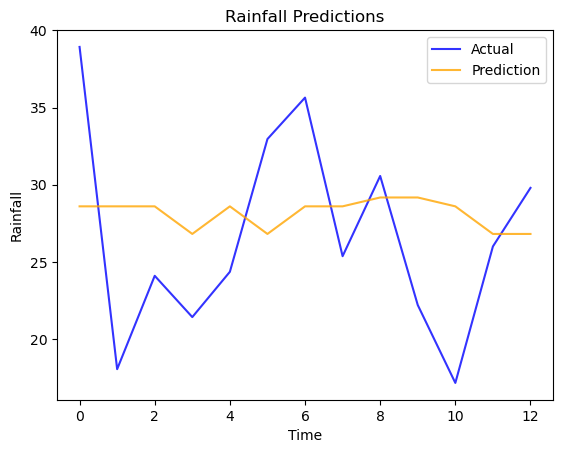

               StationName  County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                      
1959-10-01  Pepperdine Camp  Modoc                     16.430       1959 -120.246323  41.454164
1960-10-01  Pepperdine Camp  Modoc                     19.870       1960 -120.246323  41.454164
1961-10-01  Pepperdine Camp  Modoc                     19.635       1961 -120.246323  41.454164
1962-10-01  Pepperdine Camp  Modoc                     19.400       1962 -120.246323  41.454164
1963-10-01  Pepperdine Camp  Modoc                     31.350       1963 -120.246323  41.454164
1964-10-01  Pepperdine Camp  Modoc                     25.170       1964 -120.246323  41.454164
1965-10-01  Pepperdine Camp  Modoc                     26.770       1965 -120.246323  41.454164
1966-10-01  Pepperdine Camp  Modoc                     18.150       1966 -120.246323  41.454164
1967-10-01  Pepperdine Camp  Modoc      

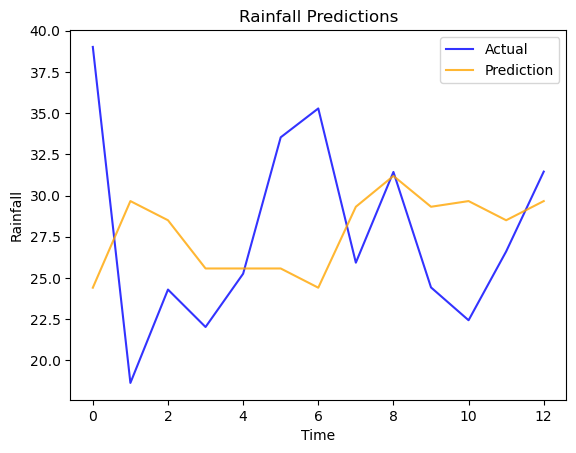

               StationName  County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                      
1961-10-01  Plaskett Meadow   Glen                      48.30       1961 -122.857873  39.735429
1962-10-01  Plaskett Meadow   Glen                      49.04       1962 -122.857873  39.735429
1963-10-01  Plaskett Meadow   Glen                      54.24       1963 -122.857873  39.735429
1964-10-01  Plaskett Meadow   Glen                      45.55       1964 -122.857873  39.735429
1965-10-01  Plaskett Meadow   Glen                      93.25       1965 -122.857873  39.735429
1966-10-01  Plaskett Meadow   Glen                      46.45       1966 -122.857873  39.735429
1967-10-01  Plaskett Meadow   Glen                      66.24       1967 -122.857873  39.735429
1968-10-01  Plaskett Meadow   Glen                      50.66       1968 -122.857873  39.735429
1969-10-01  Plaskett Meadow   Glen      

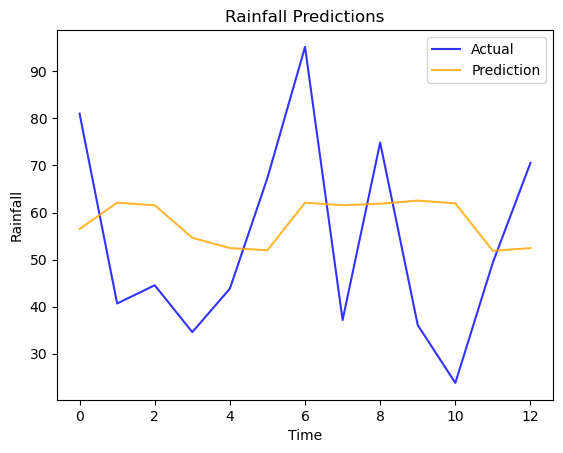

           StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                   
1946-10-01  Saddle Camp  Tehama                      20.00       1946 -122.801191  40.165379
1947-10-01  Saddle Camp  Tehama                      18.15       1947 -122.801191  40.165379
1948-10-01  Saddle Camp  Tehama                      26.25       1948 -122.801191  40.165379
1949-10-01  Saddle Camp  Tehama                      28.13       1949 -122.801191  40.165379
1950-10-01  Saddle Camp  Tehama                      23.19       1950 -122.801191  40.165379
1951-10-01  Saddle Camp  Tehama                      30.88       1951 -122.801191  40.165379
1952-10-01  Saddle Camp  Tehama                      39.69       1952 -122.801191  40.165379
1953-10-01  Saddle Camp  Tehama                      34.97       1953 -122.801191  40.165379
1954-10-01  Saddle Camp  Tehama                      35.45       1954 

C:\Users\dfang\AppData\Local\Temp\ipykernel_108232\2114243854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rolling_mean'] = data["TotalPrecipitation_inches"].rolling(window=window_size).mean()


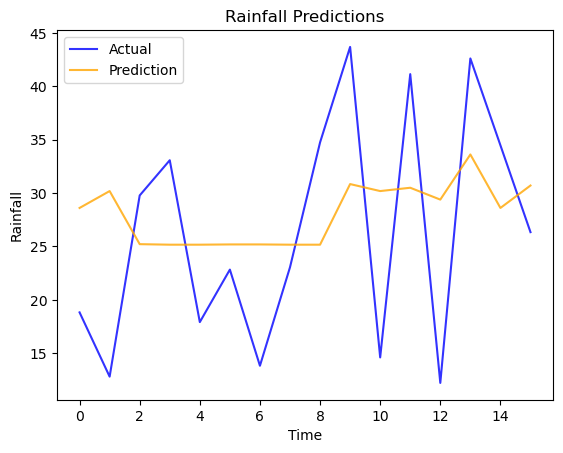

                StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                        
1991-10-01  Shaffer Mountain  Lassen                  18.200000       1991 -120.357534  40.447365
1992-10-01  Shaffer Mountain  Lassen                  14.200000       1992 -120.357534  40.447365
1993-10-01  Shaffer Mountain  Lassen                  36.970000       1993 -120.357534  40.447365
1994-10-01  Shaffer Mountain  Lassen                  19.680000       1994 -120.357534  40.447365
1995-10-01  Shaffer Mountain  Lassen                  44.750000       1995 -120.357534  40.447365
1996-10-01  Shaffer Mountain  Lassen                  42.070000       1996 -120.357534  40.447365
1997-10-01  Shaffer Mountain  Lassen                   9.800000       1997 -120.357534  40.447365
1998-10-01  Shaffer Mountain  Lassen                  17.350000       1998 -120.357534  40.447365
1999-10-01  Shaffer 

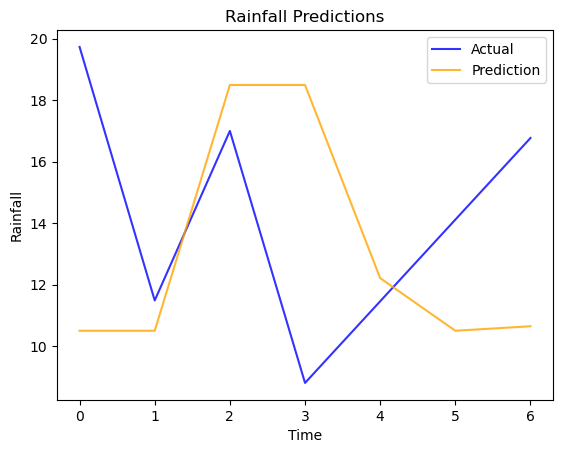

             StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                     
1947-10-01  Stouts Meadow  Shasta                      68.17       1947 -121.939585  41.168906
1948-10-01  Stouts Meadow  Shasta                      89.91       1948 -121.939585  41.168906
1949-10-01  Stouts Meadow  Shasta                      60.55       1949 -121.939585  41.168906
1950-10-01  Stouts Meadow  Shasta                      57.50       1950 -121.939585  41.168906
1951-10-01  Stouts Meadow  Shasta                     109.70       1951 -121.939585  41.168906
1952-10-01  Stouts Meadow  Shasta                     109.16       1952 -121.939585  41.168906
1953-10-01  Stouts Meadow  Shasta                      88.50       1953 -121.939585  41.168906
1954-10-01  Stouts Meadow  Shasta                      41.10       1954 -121.939585  41.168906
1955-10-01  Stouts Meadow  Shasta                 

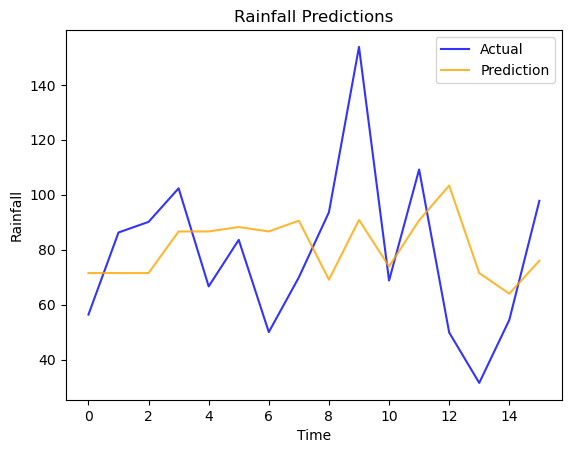

              StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                      
1959-10-01  Swain Mountain  Lassen                    41.1900       1959 -121.100349  40.444958
1960-10-01  Swain Mountain  Lassen                    44.1200       1960 -121.100349  40.444958
1961-10-01  Swain Mountain  Lassen                    45.3300       1961 -121.100349  40.444958
1962-10-01  Swain Mountain  Lassen                    50.6500       1962 -121.100349  40.444958
1963-10-01  Swain Mountain  Lassen                    48.5600       1963 -121.100349  40.444958
1964-10-01  Swain Mountain  Lassen                    41.5100       1964 -121.100349  40.444958
1965-10-01  Swain Mountain  Lassen                    63.4200       1965 -121.100349  40.444958
1966-10-01  Swain Mountain  Lassen                    37.1200       1966 -121.100349  40.444958
1967-10-01  Swain Mountain  Lassen      

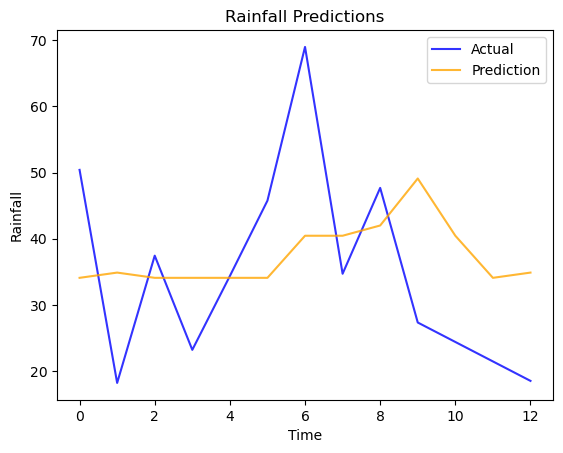

             StationName  County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                    
1959-10-01  Sweagert Flat  Modoc                      15.61       1959 -120.794337  41.237361
1960-10-01  Sweagert Flat  Modoc                      19.07       1960 -120.794337  41.237361
1961-10-01  Sweagert Flat  Modoc                      19.30       1961 -120.794337  41.237361
1962-10-01  Sweagert Flat  Modoc                      21.34       1962 -120.794337  41.237361
1963-10-01  Sweagert Flat  Modoc                      31.12       1963 -120.794337  41.237361
1964-10-01  Sweagert Flat  Modoc                      22.97       1964 -120.794337  41.237361
1965-10-01  Sweagert Flat  Modoc                      31.91       1965 -120.794337  41.237361
1966-10-01  Sweagert Flat  Modoc                      18.23       1966 -120.794337  41.237361
1967-10-01  Sweagert Flat  Modoc                      25.88 

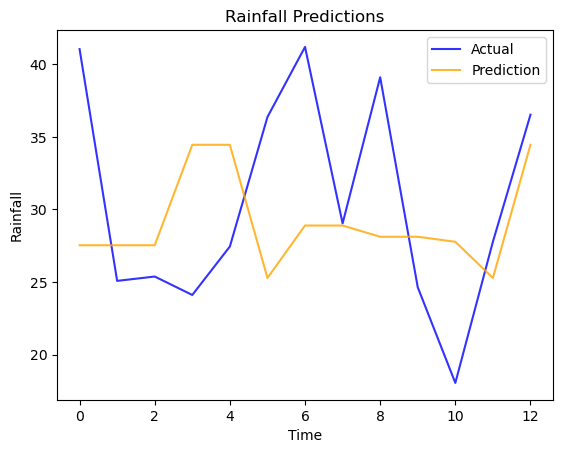

                 StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                         
1960-10-01  Three Mile Valley  Plumas                  28.610000       1960 -120.571455  39.901697
1961-10-01  Three Mile Valley  Plumas                  20.870000       1961 -120.571455  39.901697
1962-10-01  Three Mile Valley  Plumas                  26.260000       1962 -120.571455  39.901697
1963-10-01  Three Mile Valley  Plumas                  49.140000       1963 -120.571455  39.901697
1964-10-01  Three Mile Valley  Plumas                  20.570000       1964 -120.571455  39.901697
1965-10-01  Three Mile Valley  Plumas                  47.440000       1965 -120.571455  39.901697
1966-10-01  Three Mile Valley  Plumas                  25.590000       1966 -120.571455  39.901697
1967-10-01  Three Mile Valley  Plumas                  45.160000       1967 -120.571455  39.901697
1968-10-01

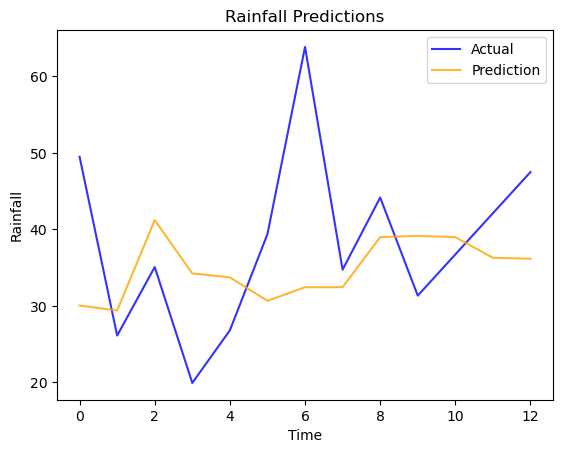

In [23]:
errors_list = []
predictions_list = []
for station in list(grouped_data):
    station_maes = []
    station_rmses = []

    station_name = station[0]
    station = station[1]
    # Resample Station data to ensure consistent frequency and fill any missing dates
    station = duplicate_years(station)
    station = station.dropna()
    station.index = pd.to_datetime(station["WaterYear"].astype(str) + "-10-01")
    try:
        station = station.resample("YS-OCT").asfreq()
    except:
        print(station.to_string())

    # Applying lag feature creation to the dataset
    #station = create_lag_features(station, lag_steps = 5)
    # Applying rolling mean to the dataset
    station = create_rolling_mean(station, window_size = 5)
    #station = apply_fourier_transform(station)

    #X1 = station[['lag_1', 'lag_2', 'lag_3']]
    X2 = station['rolling_mean'] #We picked the rolling mean because precipitation data is susceptible to unnecessary trends (record high/low rainfall years)
    #X3 = station['fourier_transform']
    y = station['TotalPrecipitation_inches']

    X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, shuffle=False)

    param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0]
    }
    grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=3)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    # Training the XGBoost model
    xgb_model = XGBRegressor(**best_params)
    xgb_model.fit(X_train, y_train)

    # Evaluating the XGBoost model on the testing set
    predictions = xgb_model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    errors_list.append([mae, rmse])

    #plt.plot(y_train.values, label = 'Training', color = 'green', alpha = 0.8)

    # Plot actual values
    plt.plot(y_test.values, label='Actual', color='blue', alpha=0.8)

    # Plot predicted values
    plt.plot(predictions, label='Prediction', color='orange', alpha=0.8)

    plt.xlabel('Time')
    plt.ylabel('Rainfall')
    plt.title('Rainfall Predictions')
    plt.legend()
    plt.show()

In [26]:
new_df = pd.DataFrame(errors_list, columns = ['mae', 'rmse'])
print(new_df.to_string())

          mae       rmse
0   16.351493  18.300388
1    6.186548   7.415933
2    6.680349   8.306380
3    8.833725  11.116612
4   26.461064  28.692589
5    6.512382   7.870509
6    5.475630   7.043447
7    6.157703   8.578301
8    3.910301   4.802999
9    7.468662   8.408936
10   2.929976   3.471032
11   4.162654   4.694116
12   4.904127   6.377554
13   8.366054   9.701170
14   7.210807   9.945952
15  10.188766  12.642979
16   6.413843   8.551480
17   7.309407   9.131933
18  11.187470  12.705222
19  11.827969  13.639907
20  14.555034  16.770411
21  22.035328  25.834851
22  14.302470  16.297875
23  18.668549  24.280825
24   5.763434   6.636076
25   5.533253   7.020356
26  20.214743  22.219988
27   9.241101  10.358976
28   4.552328   5.770333
29  23.883549  28.715490
30  12.750831  14.785894
31   6.752821   8.142242
32   9.607595  12.409000
